# Final Exam

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* You have **180 minutes** to complete the exam.
* For every minute late you submit the exam, you will lose one point.
Final Exam

Submission
* You will upload your solution to the Final Exam assignment on Canvas, where you downloaded this.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

Answer Quality
* For conceptual questions, note that we will grade your answer for its relevance to our course focus and discussion. 
* Making points that are irrelevant, out-of-context, or overly general will may not help and could hurt your score for the question.
* This may be particularly relevant for answers which are copied from LLMs such as ChatGPT, but do not get at the heart of our contextual course learning.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 20     |
| 2       | 25     |
| 3       | 50     |
| 4       | 55     |
| **Total**   | **150**|

#### Each numbered question is worth 5pts unless otherwise noted.

***

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `exam_data_2024-03-05.xlsx`

This file has sheets for...
* curve data - discount factors and forward volatilities
* BDT tree of rates (continuously compounded, as usual)
* vol quotes (across strikes) on swaptions for a particular expiry and tenor
* SABR parameters for a vol skew of the expiry and tenor associted with the vol quotes on the previous sheet.

Note
* the curve data is given at quarterly frequency
* all rates reported in the curve data are quarterly compounded, which is conveneint for the study of quarterly products in this exam (whether caps, floors, swaps, etc.)

### Load Data

If useful, the following code loads the data:

In [1]:
import numpy as np
import pandas as pd

In [2]:
DATE = '2024-03-05'

FILEIN = f'../data/exam_data_{DATE}.xlsx'

sheet_curves = 'rate curves'
sheet_tree = 'rate tree'
sheet_volskew = 'bloomberg vcub'
sheet_sabrparams = 'sabr params'

curves = pd.read_excel(FILEIN, sheet_name=sheet_curves)

ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree)
ratetree.columns.name = 'time'

volskew = pd.read_excel(FILEIN, sheet_name=sheet_volskew)

sabrparams = pd.read_excel(FILEIN, sheet_name=sheet_sabrparams)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.optimize import minimize

def Blacks_formula(sigma, maturity, strike, F, discount, price='Call'):
    '''
    Inputs: Volatility, Maturity, strike, Forward, discount, and type of option 'Call' or 'Put'
    Returns option's price.
    '''
    vol=sigma
    T=maturity
    K=strike
    Z=discount
    d1=(np.log(F/K)+(((vol**2)*T)/2))/(vol*(T**(1/2)))
    d2=d1-(vol*(T**(1/2)))
    if price=='Call':
        return Z*((F*norm.cdf(d1))-(K*norm.cdf(d2)))
    if price=='Put':
        return Z*((K*norm.cdf(-d2))-(F*norm.cdf(-d1)))

def price_cap_floor(sigma, maturity, strike, F, discount, instrument='Cap', n=4):
    if np.isnan(sigma):
        return np.nan
    if instrument=='Cap':
        price='Call'
    if instrument == 'Floor':
        price='Put'
    tp=0
    for i in range(2,int(n*maturity)+1):
        tp+=Blacks_formula(sigma, (i/n)-(1/n), strike, F[i-1], discount[i-1], price)
    return (100/n)*tp

def forward_vols_from_instrument_prices(cap_prices, maturities, strikes, Fs, discounts, price='Call'):
    cap_prices=np.array(cap_prices)
    maturities=np.array(maturities)
    strikes=np.array(strikes)
    Fs=np.array(Fs)
    discounts=np.array(discounts)

    n=1/(maturities[1]-maturities[0])
    res=np.zeros((len(cap_prices)))
    
    for i, cap_price in enumerate(cap_prices):
        if np.isnan(cap_price):
            res[i]=np.nan
        else:
            tp=0
            for ii in range(i):
                if not np.isnan(res[ii]):
                    tp+=Blacks_formula(res[ii],maturities[ii-1],strikes[i],Fs[ii],discounts[ii],price)
            ttp=cap_price-(tp*100/n)
            def helper(sigma):
                return ((Blacks_formula(sigma, maturities[i-1], strikes[i], Fs[i], discounts[i], price)*100/n) - (ttp))**2
            res[i]=minimize(helper,[0.05], tol=1e-8).x[0]
    return res

def continuous_from_discount(discount, maturity):
    '''Returns the continuous rate from the discount factor and the maturity'''
    return -np.log(discount)/maturity

def compounded_from_discount(discount, maturity, freq=2):
    '''Returns the compounded rate from the discount factor and the maturity'''
    return ((1/discount)**(1/(maturity*freq))-1)*freq

def discount_from_continuous(continuous, maturity):
    '''Returns the discount factor from the continuous rate and the maturity'''
    return np.exp(-continuous*maturity)

def discount_from_compounded(compounded, maturity, freq=2):
    '''Returns the discount factor from the compounded rate and the maturity'''
    return (1+compounded/freq)**(-maturity*freq)

def display_tree(periods, levels, attribute):
    temp=pd.DataFrame()
    for i in range(1,len(levels)+1):
        temp_level=[]
        for j in range(len(levels[-i])):
            temp_level.append(getattr(levels[-i][j],attribute))
        temp[round(periods[-i],2)]=temp_level+['']*(len(levels[-1])-len(temp_level))
    temp.sort_index(axis=1, inplace=True)
    temp.columns=temp.columns.astype(str)
    return temp.style.format("{:.2}")
        
def display_tree_no_attribute(periods, levels):
    temp=pd.DataFrame()
    for i in range(1,len(levels)+1):
        temp_level=[]
        for j in range(len(levels[-i])):
            temp_level.append(levels[-i][j])
        temp[round(periods[-i],2)]=temp_level+['']*(len(levels[-1])-len(temp_level))
    temp.sort_index(axis=1, inplace=True)
    temp.columns=temp.columns.astype(str)
    return temp
    
class tree_convention:
    UP=1
    DOWN=-1
    ORIGIN=0
    TERMINAL=2
    DUMMY=3
    
class interest_node():
    def __init__(self, period, rate, state=tree_convention.DUMMY):
        self.period = period
        self.rate = rate
        self.state = state

    def __repr__(self):
        return 'rate: {:.2%}\nperiod: {}\nstate: {}'.format(self.rate,self.period,self.state)
    
class Interest_Tree():
    def __init__(self, periods, rates=None):
        self.periods = periods
        self.rates = rates
        self.levels = []

    def tree_from_discounts_theta_sigma(self,discounts,theta,sigma,freq=4):
        self.levels.append([interest_node(0,continuous_from_discount(discounts[0],1/freq),tree_convention.ORIGIN)])
        for i in range(1,len(self.periods)):
            tlevel=[]
            ttheta=theta[i-1]
            tsigma=sigma[i-1]
            for j in range(len(self.levels[i-1])):
                trate=self.levels[i-1][j].rate
                tlrate=np.log(trate*100)
                tlrateup=tlrate+(ttheta*(1/freq))+(tsigma*np.sqrt(1/freq))
                trateup=np.exp(tlrateup)/100                   
                node=interest_node(self.periods[i],trateup)
                tlevel.append(node)
                if j == i-1:
                    tlratedown=tlrate+(ttheta*(1/freq))-(tsigma*np.sqrt(1/freq))
                    tratedown=np.exp(tlratedown)/100
                    node=interest_node(self.periods[i],tratedown)
                    tlevel.append(node)
            self.levels.append(tlevel)

    def __repr__(self):
        tree_str = 'Rates_Tree [%]:\n'
        for level_index, level in enumerate(self.levels):
            level_str = '  ' * level_index
            for node in level:
                node_str = '{:.2f}'.format(
                    node.rate*100)
                level_str += node_str + ' '
            tree_str += 'period: {} ||'.format(node.period) + level_str.strip() + '\n'
        return tree_str.strip()
                

class bond_node():
    def __init__(self, period, price, state, maturity,expected_price=None):
        self.period = period
        self.price = price
        self.state = state
        self.maturity = maturity
        self.expected_price=expected_price
        self.rn_probUP=1/2
        self.rn_probDOWN=1/2

    def __repr__(self):
        return 'period: {}\nstate: {}\nprice: {:.2f}\nmaturity: {}'.format(self.period, self.state, self.price, self.maturity)

class Binary_Bond_Tree():
    def __init__(self, periods=None, price=None, face_value=100, interest_tree=None, maturity=None):
        self.periods = np.array(periods)
        if len(price)<=1:
            self.price=price
        else:
            self.price=np.array(price)
        self.face_value = face_value
        self.levels = []
        self.interest_tree = interest_tree
        self.maturity = maturity
        self.thetas=[]
        self.sigmas=np.zeros(())

    def tree_from_sigmas(self,sigmas,periods=None, prices=None):
        sigmas=np.array(sigmas)
        if periods is not None:
            self.periods=periods
        freq=1/(self.periods[1]-self.periods[0])
        if prices is not None:
            self.price=prices
        self.sigmas=sigmas
        for i in range(len(self.periods)-2):
            def helper(theta):
                ttree=Interest_Tree(self.periods[:i+2])
                ttree.tree_from_discounts_theta_sigma(self.price[:i+2]/100,np.append(self.thetas[:i],theta),sigmas[:i+2],freq)
                tjprices=[]
                for j in range(len(ttree.levels[-1])):
                    tjprices.append(self.face_value*np.exp(-ttree.levels[-1][j].rate*(1/freq)))
                for j in range(2,len(ttree.levels)+1):
                    tkprices=[]
                    for k in range(len(ttree.levels[-j])):
                        average=(tjprices[k]+tjprices[k+1])/2
                        tkprice=average*np.exp(-ttree.levels[-j][k].rate*(1/freq))
                        tkprices.append(tkprice)
                    tjprices=tkprices
                if len(tjprices)!=1:
                    print('Error', len(tjprices))
                return (tjprices[0]-self.price[i+1])**2
            theta=minimize(helper,[0.5], tol=1e-8).x[0]
            self.thetas.append(theta)
        ttree=Interest_Tree(self.periods[:-1])
        ttree.tree_from_discounts_theta_sigma(self.price/100,self.thetas,sigmas,freq)
        self.interest_tree=ttree

    def __repr__(self):
        tree_str = 'Binary_Bond_tree:\n'
        tree_str += '                               Maturity: {}\n'.format(self.maturity)
        for level_index, level in enumerate(self.levels[:-1]):
            level_str = '  ' * level_index
            for node in level:
                node_str = '[state: {}, price: {:.2f}]'.format(
                    node.state, node.price)
                level_str += node_str + '  '
            tree_str += 'period: {} '.format(node.period) + level_str.strip() + '\n'
        return tree_str.strip()
    

import numpy.polynomial.polynomial as poly


### SABR

def alpha_polynomial(beta, nu, rho, T, volATM, f):
    
    coefs = np.ones(4)
    coefs[0] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[1] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[2] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[3] = -volATM * f**(1-beta)
    
    return np.poly1d(coefs)

def solve_alpha(beta, nu, rho, T, volATM, f):
    coefs = np.ones(4)
    coefs[3] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[2] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[1] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[0] = -volATM * f**(1-beta)

    roots = poly.polyroots(coefs)
    alpha = np.real(roots[np.abs(np.imag(roots))<1e-6][0])
    return alpha

def zfun(beta, nu, alpha, f, K):
    return (nu/alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

def chi(z, rho):
    return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))

def sabr_slim(beta,nu,rho,f,K,T,volATM):

    alpha = solve_alpha(beta, nu, rho, T, volATM, f)
    
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * ((np.log(f/K))**2) + (((1-beta)**4)/1920) * ((np.log(f/K))**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
        
    if (type(K) is np.float64) | (type(K) is float):
        if (f==K):
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB




def sabr(beta,nu,rho,alpha,f,K,T):
   
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)
    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN
    z = zfun(beta,nu,alpha,f,K)        
    sigmaB = (NUM/DEN) * (z/chi(z,rho))
    
    if (type(K) is np.float64) | (type(K) is float):
        if f==K:
            sigmaB = sabrATM(beta,nu,rho,alpha,f,K,T)
    else:
        mask = f==K
        sigmaB[mask] = sabrATM(beta,nu,rho,alpha,f,K[mask],T)
        
    return sigmaB



def sabrATM(beta,nu,rho,alpha,f,K,T):
    brack = (((1-beta)**2)/24) * ((alpha**2)/(f**(2-2*beta))) + (rho * beta * nu * alpha)/(4*f**(1-beta)) + ((2-3*rho**2)/24) * nu**2
    
    sigma = alpha * (1+brack*T) / f**(1-beta)

    return sigma


def get_strikes_from_vol_moneyness(ISCALL,opts,ts):

    phi = ISCALL * 2 - 1

    deltas = pd.DataFrame(np.array([float(col[1:3])/100 for col in opts.columns]) * phi, index=opts.columns,columns = ['delta'])

    strikes = pd.DataFrame(index=opts.index, columns=opts.columns, dtype=float)
    for t in opts.index:
        T = ts.loc[t,'Expiration Option']
        for col in deltas.index:
            strikes.loc[t,col] = bs_delta_to_strike(under = ts.loc[t,'Future Price'], delta=deltas.loc[col,'delta'], sigma=opts.loc[t,col], T=T, isCall=ISCALL)
            
            
    return strikes

def graph_vol_surface_as_strikes(dtgrid,opts,strikes,ts,label):

    fig, ax = plt.subplots(2,1,figsize=(10,10))

    for j, dt in enumerate(dtgrid.columns):

        colorgrid = ['b','r','g']

        for i, tstep in enumerate(dtgrid[dt]):
            tstep = tstep.strftime('%Y-%m-%d')
            plotdata = pd.concat([opts.loc[tstep,:],strikes.loc[tstep,:]],axis=1)
            plotdata.columns = [tstep,'strike']
            plotdata.set_index('strike',inplace=True)
            plotdata.plot(ax=ax[j],color=colorgrid[i]);

            ax[j].axvline(x=ts.loc[tstep,'Future Price'],color=colorgrid[i],linestyle='--')

            if j==0:        
                ax[j].set_title(f'Curve shock: {label}')
            elif j==1:
                ax[j].set_title(f'Underlying shock: {label}')

            if label.split(' ')[-2] == 'ED':
                ax[j].set_xlim(xmin=0,xmax=.08)
            
            plt.tight_layout()

***

# 1. Models

## 1.1. (10pts)

Be specific as to which type of data is used to estimate a binomial rate tree. Or, if the feature is assumed rather than estimated, make that clear.

How do we estimate the rate tree's...
* drift
* distribution (Ho-Lee vs Black-Derman-Toy)
* nodes
* probabilities

There are many ways to construct a tree. In particular, we can use the Black-Derman-Toy model, which assumes that the logarithm of the short interest rate evolves with a combination of effects: (1) a drift term with theta*delta_t, and a 'shock' term, with sigma*square root of delta_t. In the model we actually have two free parameters, we can solve for either probabilities or the drift. In particular, we implemented the approach to make the probabilities of up and down nodes equal 1/2 (0.5), and solved for the theta that would make the a discounted bond following the resulting rates (obeying the model) match the observed prices.

We used at each division or node up and down movements. Which is why they are binomial trees!

Rates'evolution follows the following assumption:

$$
\begin{align*}
z_{s,t+1} =& z_{s,t} + \theta_t\Delta_t + \sigma\sqrt{\Delta_t}\\
z_{s+1,t+1} =& z_{s,t} + \theta_t\Delta_t - \sigma\sqrt{\Delta_t}\\
r_{s,t} = & \frac{1}{100}e^{z_{s,t}}
\end{align*}
$$

## 1.2.

Consider an interest-rate cap with only a single caplet. Which of the following could we use as an underlying binomial tree to price this cap?

* interest-rate tree
* bond tree
* swap tree
* floor tree

The ideal choice would be an interest-rate tree (which we can use to directly price a caplet). Although it sounds like the other alternatives would also be related to the underlying interest rate tree and we could (perhaps, with enough information) reconstruct a tree, it would not be optimal.

## 1.3.

True or False: SABR is used to have structure in modeling implied volatilities across strikes, tenors, and expirations.

True!

The SABR model is indeed used to provide structure in modeling implied volatilities across different strikes, tenors, and expirations. It is particularly valued for its ability to capture the volatility smile, a term used to describe the pattern where implied volatility differs for options with different strikes or expirations.

***

# 2. Pricing with BDT and Black

Use `rate curves` for market data.

## 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`

In [4]:
df=curves.copy()

In [5]:
x=df.iloc[-1]
tprice=100*Blacks_formula(x['flat vols'],3-1/4,x['swap rates'],x['forwards'],x['discounts'],price='Put')
print('Price of the floorlet:', round(tprice,3))

Price of the floorlet: 1.061


## 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [6]:
df['Floor_Price']=df.apply(lambda x: price_cap_floor(x['flat vols'], x['tenor'], x['swap rates'], np.array(df['forwards']), np.array(df['discounts']),instrument='Floor'), axis=1)
df[['tenor','Floor_Price']]

,tenor,Floor_Price
0,0.25,NaN
1,0.50,0.045010
2,0.75,0.120126
3,1.00,0.224514
4,1.25,0.407770
5,1.50,0.609006
6,1.75,0.822171
7,2.00,1.040902
8,2.25,1.263776
9,2.50,1.482204


## 2.3.

Use `rate tree` for a BDT binomial tree fit to market data for your convenience.

Use this binomial tree to price the floor described above.

Display the binomial tree of prices.

## **Please note that I built my own tree and sometimes the values are slightly different. They were very close for all the homeworks, but sometimes they differ a bit. Nothing substantial, but the numbers should be A LITTLE (!) different!!** Thank you!

In [7]:
Tree=Binary_Bond_Tree(periods=np.arange(0,3.25,1/4),price=np.array(df['discounts'])*100)
Tree.tree_from_sigmas(np.array(df['fwd vols']))

In [8]:
display_tree(Tree.periods,Tree.interest_tree.levels,'rate')

,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0
0,0.052,0.054,0.055,0.056,0.054,0.056,0.059,0.065,0.069,0.079,0.092,0.11
1,,0.047,0.048,0.048,0.047,0.049,0.052,0.056,0.06,0.068,0.08,0.093
2,,,0.042,0.042,0.04,0.042,0.045,0.049,0.052,0.059,0.069,0.081
3,,,,0.035,0.034,0.035,0.038,0.041,0.043,0.05,0.058,0.068
4,,,,,0.027,0.028,0.03,0.033,0.035,0.04,0.047,0.055
5,,,,,,0.02,0.021,0.023,0.025,0.028,0.033,0.038
6,,,,,,,0.015,0.016,0.017,0.019,0.022,0.026
7,,,,,,,,0.011,0.011,0.013,0.015,0.018
8,,,,,,,,,0.0076,0.0087,0.01,0.012
9,,,,,,,,,,0.0059,0.0069,0.008


In [9]:
face=100
rates=Tree.interest_tree
freq=1/(Tree.periods[1]-Tree.periods[0])
tprices=[]
historical=[]
for j in range(len(rates.levels[-1])):
    trate=rates.levels[-1][j].rate
    tprices.append((max(0,100*(df['swap rates'].iloc[-1]-trate)))*np.exp(-trate*(1/freq)))
historical.append(tprices)
for j in range(2,len(rates.levels)+1):
    tkprices=[]
    for k in range(len(rates.levels[-j])):
        average=(tprices[k]+tprices[k+1])/2
        fact=np.exp(-rates.levels[-j][k].rate*(1/freq))
        tkprice=average*fact
        tkprices.append(tkprice)
    tprices=tkprices
    historical.append(tprices)

historical=historical[::-1]
pd.DataFrame(historical).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.006864,0.731509,0.483481,0.279475,0.132220,0.044963,0.007915,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaN,1.308511,0.999393,0.700873,0.434583,0.223043,0.083277,0.016067,0.000000,0.000000,0.000000,0.000000
2,NaN,NaN,1.648463,1.321932,0.984258,0.656299,0.368258,0.152652,0.032589,0.000000,0.000000,0.000000
3,NaN,NaN,NaN,2.009392,1.687600,1.332227,0.958259,0.592177,0.276469,0.066027,0.000000,0.000000
4,NaN,NaN,NaN,NaN,2.366743,2.071645,1.729808,1.342416,0.920053,0.492928,0.133703,0.000000
5,NaN,NaN,NaN,NaN,NaN,2.694238,2.443062,2.143486,1.786998,1.363307,0.862072,0.270547
6,NaN,NaN,NaN,NaN,NaN,NaN,2.972389,2.768667,2.524847,2.232650,1.883771,1.467789
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.197799,3.034489,2.838293,2.603089,2.320983
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.378242,3.247902,3.091973,2.904968
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.521438,3.418012,3.294729


In [10]:
print('Price of the floorlet at T=3:',round(historical[0][0],3))

Price of the floorlet at T=3: 1.007


## 2.4.

What do you think is the most relevant reason for the difference in pricing between Black's formula and BDT?

We are assuming a constant volatility when using Black's formula! It is changing as we move through the tree, so one would expect that to influence the price.

Additionally, there are secondary effects in the modeling of tree itself (e.g.,grid spacing)

## 2.5.

Use the BDT tree to price a swap...
* `receiving-fixed` 
* swap rate of `3.65%`
* tenor `T=3`
* notional `N=100`.
* frequency quarterly (`n=4`)

Display the pricing tree.

In [11]:
tlevels=Tree.interest_tree.levels
ttlevels=[]
for i in tlevels:
    temp=[]
    for ii in i:
        temp.append(ii.rate)
    ttlevels.append(temp)

ann_compounded=[]
mat=1/4
for i in ttlevels:
    temp=[]
    for j in i:
        temp.append(compounded_from_discount(discount_from_continuous(j,mat),mat,4))
    ann_compounded.append(temp)
    mat+=1/4

tdf=pd.DataFrame(ann_compounded).T
tdf.columns=Tree.periods[1:]
print('Rate tree, quarterly compounded rates:')
tdf

Rate tree, quarterly compounded rates:


,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
0,0.052226,0.054287,0.055373,0.056193,0.053946,0.056280,0.059908,0.065273,0.069152,0.079430,0.092805,0.108567
1,NaN,0.047128,0.048069,0.048781,0.046832,0.048856,0.052002,0.056655,0.060018,0.068927,0.080516,0.094167
2,NaN,NaN,0.041734,0.042351,0.040660,0.042417,0.045146,0.049182,0.052098,0.059823,0.069868,0.081695
3,NaN,NaN,NaN,0.035393,0.033981,0.035448,0.037727,0.041096,0.043530,0.049976,0.058356,0.068219
4,NaN,NaN,NaN,NaN,0.027376,0.028557,0.030391,0.033102,0.035061,0.040247,0.046986,0.054914
5,NaN,NaN,NaN,NaN,NaN,0.020024,0.021309,0.023208,0.024579,0.028209,0.032925,0.038469
6,NaN,NaN,NaN,NaN,NaN,NaN,0.014594,0.015893,0.016831,0.019314,0.022539,0.026328
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010715,0.011347,0.013020,0.015192,0.017743
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007611,0.008733,0.010188,0.011898
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005881,0.006860,0.008011


In [12]:
swap_rate=0.0365

coupPay=True
coupon=swap_rate
freq_b=4
face=100
rates=Tree.interest_tree
freq=1/(Tree.periods[1]-Tree.periods[0])
tprices=[]
historical=[]
for j in range(len(rates.levels[-1])):
    tprices.append((face*(1+(coupPay*coupon/freq_b)))*np.exp(-rates.levels[-1][j].rate*(1/freq)))
historical.append(tprices)
for j in range(2,len(rates.levels)+1):
    tkprices=[]
    for k in range(len(rates.levels[-j])):
        average=(tprices[k]+tprices[k+1])/2
        average+=coupPay*face*coupon/freq_b
        fact=np.exp(-rates.levels[-j][k].rate*(1/freq))
        tkprice=average*fact
        tkprices.append(tkprice)
    tprices=tkprices
    historical.append(tprices)

historical=historical[::-1]
tdf=pd.DataFrame(historical).T
tdf.columns=Tree.periods[1:]
tdf=tdf-100
tdf

,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
0,-1.262792,-1.937657,-2.513151,-3.002164,-3.401150,-3.780968,-4.025549,-4.098829,-3.952906,-3.617864,-2.921150,-1.754071
1,NaN,0.165399,-0.525385,-1.150081,-1.702878,-2.240795,-2.653799,-2.902461,-2.939859,-2.792018,-2.311760,-1.408512
2,NaN,NaN,1.391485,0.665153,-0.011294,-0.688261,-1.264729,-1.699016,-1.939530,-2.000026,-1.747157,-1.107272
3,NaN,NaN,NaN,2.408566,1.648257,0.873461,0.169444,-0.426685,-0.866204,-1.149658,-1.146586,-0.779677
4,NaN,NaN,NaN,NaN,3.156164,2.325119,1.540347,0.830104,0.233845,-0.250107,-0.507639,-0.454126
5,NaN,NaN,NaN,NaN,NaN,3.574233,2.745937,1.968555,1.270219,0.649956,0.189754,-0.048754
6,NaN,NaN,NaN,NaN,NaN,NaN,3.614533,2.793030,2.025120,1.310056,0.704797,0.252628
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.367104,2.552784,1.773795,1.068689,0.466853
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.910216,2.088619,1.316447,0.613222
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.298450,1.481543,0.710793


In [13]:
print('Price of the swap at T=3:',round(tdf.iloc[0,0],3))

Price of the swap at T=3: -1.263


***

# 3. Callable Bond

#### Note:
Continue with the rate curves and BDT model provided in `rate curves` and `rate tree` in the provided spreadsheet.

## 3.1.

Consider a bond with:
* `T=3`
* face value of `N=100`
* coupons at `quarterly` frequency
* annualized coupon rate of `cpn=6%`.

Use your BDT tree to price this bond and display the pricing tree.

In [14]:
coupPay=True
coupon=0.06
freq_b=4
face=100
rates=Tree.interest_tree
freq=1/(Tree.periods[1]-Tree.periods[0])
tprices=[]
historical=[]
for j in range(len(rates.levels[-1])):
    tprices.append((face*(1+(coupPay*coupon/freq_b)))*np.exp(-rates.levels[-1][j].rate*(1/freq)))
historical.append(tprices)
for j in range(2,len(rates.levels)+1):
    tkprices=[]
    for k in range(len(rates.levels[-j])):
        average=(tprices[k]+tprices[k+1])/2
        average+=coupPay*face*coupon/freq_b
        fact=np.exp(-rates.levels[-j][k].rate*(1/freq))
        tkprice=average*fact
        tkprices.append(tkprice)
    tprices=tkprices
    historical.append(tprices)

historical=historical[::-1]
print('The price of the bond through the tree is {:.2f}'.format(tprices[0]))

The price of the bond through the tree is 105.31


In [15]:
tdf=pd.DataFrame(historical).T
tdf.columns=Tree.periods[1:]
tdf


,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00
0,105.307541,104.097983,102.988634,101.964501,101.028200,100.104642,99.314558,98.694128,98.291173,98.072860,98.213018,98.817905
1,NaN,106.266997,105.032940,103.864149,102.765647,101.676766,100.711655,99.909845,99.318130,98.908007,98.827669,99.165476
2,NaN,NaN,107.005135,105.726165,104.495939,103.260864,102.125637,101.132092,100.331759,99.708688,99.397052,99.468469
3,NaN,NaN,NaN,107.516995,106.195219,104.855436,103.586081,102.424470,101.419342,100.568371,100.002742,99.797971
4,NaN,NaN,NaN,NaN,107.741464,106.339322,104.983236,103.701672,102.534193,101.477702,100.647021,100.125417
5,NaN,NaN,NaN,NaN,NaN,107.618394,106.213773,104.860081,103.585536,102.388169,101.350481,100.533150
6,NaN,NaN,NaN,NaN,NaN,NaN,107.100509,105.699123,104.351408,103.055931,101.870014,100.836286
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.283400,104.886777,103.525072,102.237083,101.051758
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.249439,103.843570,102.487008,101.198979
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.055849,102.653547,101.297119


## 3.2. (7pts)

Suppose the bond is callable by the issuer.

* `European` style
* expiration of `Topt=1.5`
* (clean) `strike=100`

What is the value of the issuer's call option?

*Note that there is no difference between clean or dirty strike given that the bond pays coupons quarterly, and we are looking at quarterly steps in the tree.*

In [16]:
clean=[]
for i in historical[:7]:
    clean.append(i.copy())

tlevels=Tree.interest_tree.levels
ttlevels=[]
for i in tlevels:
    temp=[]
    for ii in i:
        temp.append(ii.rate)
    ttlevels.append(temp)

tttlevels=[]
for i in tlevels[:7]:
    temp=[]
    for ii in i:
        temp.append(ii.rate)
    tttlevels.append(temp)

temp=[max(0,i-100) for i in clean[-1]]
callable=[]
callable.append(temp.copy())
for j in range(2,len(tttlevels)+1):
    tkprices=[]
    for k in range(len(clean[-j])):
        average=(temp[k]+temp[k+1])/2
        tkprice=average*np.exp(-rates.levels[-j][k].rate*(1/freq))
        # tkprices.append(max(tkprice, max(0,clean[-j][k]-100)))
        tkprices.append(tkprice)
    temp=tkprices
    callable.append(temp.copy())

callable=callable[::-1]
display_tree_no_attribute(Tree.periods[1:8], callable)

,0.25,0.5,0.75,1.0,1.25,1.5,1.75
0,3.264047,2.660937,2.044283,1.432963,0.852282,0.347759,0.000000
1,,3.959007,3.357297,2.722322,2.063191,1.390654,0.711655
2,,,4.663655,4.087376,3.463146,2.806832,2.125637
3,,,,5.354617,4.818078,4.223048,3.586081
4,,,,,6.0077,5.533504,4.983236
5,,,,,,6.602792,6.213773
6,,,,,,,7.100509


## 3.3. (3pts)

What is the value of the callable bond?

The value of the callable bond is the price of the bond - value of the call option! (in case my number is off)

In [17]:
print('Value of the callable bond:',round(historical[0][0]-callable[0][0],3))

Value of the callable bond: 102.043


## 3.4.

We found that the Freddie Mac callable bonds often have negative option-adjusted spreads (OAS). 

Why was this? Do you expect that the european callable bond would be less prone to this phenomenon?

We hypothesized that a likely reason was the not-optimal exercise of the call on the bond. Sometimes when it would seem optimal to exercise, agencies may not do so, or conversely, they could also exercise when it does not seem advantageous. Given that european callable bond have only one exercise option, it is likely that european callable bonds would be less prone to this phenomenon.

## 3.5.

We found that the Freddie Mac american callable bond never priced above 100.

Does this bond ever price above 100? Explain why this is possible when it was not for the Freddie Mac callable.

The option can only be exercised at one time! (At expiry for the european)
Amercan callables can not have a value above 100 precisely because they can be called at any time (pre-especified times really, but this does not alter the argument significantly). 
This is not the case for european callables, which means that their value can be above 100 at times.

## 3.6.

Price the callable bond without using binomial trees.

* Use standard closed-form pricing for the vanilla bond, given the rate curve data.
* Use Black's formula to price the callable option.

Report this newly modeled price.

*Note: In Black's formula, use the flat volatility for the option term.*

In [18]:
x=df.iloc[5]
tprice=100*Blacks_formula(x['flat vols'],1.5-1/4,x['swap rates'],x['forwards'],x['discounts'],price='Call')
print('Price of the Call:', round(tprice,3))

Price of the Call: 0.213


## 3.7.

Which assumptions of Black's formula do we prefer to Black-Scholes for this problem?

Options on these bonds are not tradable! This is important because Black's can handle this, while it would be a violation of Black-Scholes.

Other assumptions are not too bad (frictionless markets), or are shared (geometric brownian motion, fixed rates).

## 3.8.

Which aspects of the calculation in `3.6` differ because we are using Black's formula, not Black-Scholes? 

*Note: Unlike `3.7`, we're asking about the differences of implementing the calculation, not the differences in the assumptions of the models.

We mentioned tradable assets (now onto implementation:)

Mainly, we plug in the future/forward price of the instrument and then apply the discount factor, as opposed to value of the stock.

## 3.9. 

Suppose that we buy the callable bond, but we want to hedge against it being called by the issuer. That is to say, we want to retain upside exposure to rates decreasing while otherwise keeping the nature of the position the same.

Explain specifically how you would use caps, floors, or swaptions to achieve this. 

No need to calculate the value; rather, just describe the specific product you would go long (or short) and how it would transform your exposure.

A swaption could be appropriate. Specifically, you could purchase a receiver swaption, which gives you the right but not the obligation to enter into an interest rate swap where you would receive fixed rates and pay floating rates. This strategy would hedge against the bond being called in a falling rate environment by potentially entering into a swap that benefits from lower rates, without mandating the use of this strategy unless it becomes beneficial.

## 3.10.

How would your answer to `3.9` change if it were a callable bond with **american** exercise by the issuer?

To hedge against the callable bond with American exercise you would go long on an interest rate cap. This long position in the cap, consisting of a series of caplets over the bond's lifetime, protects against falling interest rates by compensating you if rates drop below the cap's strike rate, across all potential call dates. This strategy ensures comprehensive coverage and maintains beneficial exposure to declining interest rates, effectively mitigating the callable bond's risk of being redeemed early.

***

# 4. Swaptions and SABR

## 4.1.

Use the market data in `rate curves` to calculate the relevant forward swap rate for an at-the-money (ATM) swaption with...
* `expiration=1`
* `tenor=2`

Report this forward swap rate.

In [19]:
df

,tenor,swap rates,spot rates,discounts,forwards,flat vols,fwd vols,Floor_Price
0,0.25,0.052226,0.052226,0.987112,NaN,NaN,0.140538,NaN
1,0.50,0.051470,0.051465,0.974756,0.050705,0.140538,0.140538,0.045010
2,0.75,0.050427,0.050411,0.963125,0.048303,0.161925,0.178617,0.120126
3,1.00,0.049243,0.049209,0.952268,0.045606,0.183311,0.215305,0.224514
4,1.25,0.047534,0.047467,0.942722,0.040506,0.233815,0.353890,0.407770
5,1.50,0.046112,0.046016,0.933672,0.038769,0.272932,0.377696,0.609006
6,1.75,0.044914,0.044793,0.925009,0.037462,0.302241,0.393585,0.822171
7,2.00,0.043913,0.043770,0.916617,0.036620,0.323320,0.398881,1.040902
8,2.25,0.042897,0.042729,0.908800,0.034407,0.337748,0.395042,1.263776
9,2.50,0.042107,0.041920,0.900995,0.034653,0.347102,0.386431,1.482204


In [20]:
discount3=df['discounts'].iloc[-1]
discount1=df['discounts'].iloc[3]
discount_swap=discount3/discount1
swap_rate=compounded_from_discount(discount_swap,2,4)
print('Forward swap rate:',round(swap_rate*100,3),'%')

Forward swap rate: 3.661 %


## 4.2.

#### Note

Regardless of what you calculated in the previous problem **use a forward swap rate of `.0365` for the rest of this section**, not just this specific question.

Don't worry that the forward swap rate provided here may not match your answer from the previous section. We are using it to ensure all solutions below are based on the same forward swap rate.

In [21]:
swap_rate=0.0365

#### Continuing...

Use the data in `volskew` which gives market quotes (in terms of Black vol) on swaptions across various strikes. 
* The strikes listed are relative to the ATM strike, which equals the forward swap rate given to you in the previous paragraph.
* All these quotes are for the same expiration and tenor considered in `4.1`.

Report the price of the swaption with specification of...
* struck at the money
* notional of `100`
* a `receiver` swaption

In [22]:
volskew

,reference,instrument,model,date,expiration,tenor,-300,-200,-100,-50,-25,0,25,50,100,200,300
0,SOFR,swaption,black,2024-03-05,1,2,100.35,57.7,42.28,37.82,36.15,34.8,33.74,32.93,31.94,31.56,32.14


In [23]:
vols=np.array(volskew.iloc[0,6:])/100
strikes=(np.array(volskew.columns[6:],dtype=float)/10000)+swap_rate
scale=np.sum(df['discounts'].iloc[4:])/4
prices=[]
for i in range(len(vols)):
    prices.append(100*Blacks_formula(vols[i],1,strikes[i],swap_rate,scale,'Put'))
print('Price ATM:',round(prices[-6],3))

Price ATM: 0.921


## 4.3. (10pts)

Use SABR to consider pricing for strikes which are not listed. Sepcifically,

* Input the SABR parameters given in `sabrparams` in the exam data sheet to get the implied volatility for any strike.

* To do this, choose the `SLIM` SABR model, where $\alpha$ (also called $\sigma_0$) is a function of the other SABR parameters. Thus, you won't make use of the estimated $\alpha$ parameter; rather, you'll make use of the other parameters in conjunction with the ATM market quoted vol.

Consider a `STRIKE=.03`.

Report
* the SABR-implied vol for this strike, (and the provided forward swap rate.) 
* the price for this swaption given by Black's formula.

In [24]:
sabrparams


,parameter,estimate
0,beta,0.250000
1,alpha,0.028011
2,nu,0.689461
3,rho,-0.160282


In [25]:
BETA = sabrparams.iloc[0,1]
alpha=sabrparams.iloc[1,1]
nustar=sabrparams.iloc[2,1]
rhostar=sabrparams.iloc[3,1]

doSLIM = True

In [26]:
NEWSTRIKE = .03
Topt=1
volATM=vols[-6]
F = swap_rate-1e-8

if doSLIM:
    newvol = sabr_slim(BETA,nustar,rhostar,F,NEWSTRIKE,Topt,volATM)
else:
    newvol = sabr(BETA,nustar,rhostar,alphastar,F,NEWSTRIKE,Topt)

newprice = 100 * Blacks_formula(newvol,Topt,NEWSTRIKE, swap_rate,scale,'Put')
display(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')

'Price of the OTM swaption at strike 3.00% is $0.4662.'

In [27]:
print('SABR-implied vol:',round(newvol,5))

SABR-implied vol: 0.39313


In [28]:
print('Forward swap rate:',round(F,5))

Forward swap rate: 0.0365


## 4.4. 

Suppose the forward swap rate changes by `+10bps`.

(We are considering an instantaneous change, so no need to change the time-to-expiration.)

Report
* the new price, assuming vol stays constant
* the new vol and the new price, assuming vol responds according to the SABR specification of part `4.3`.

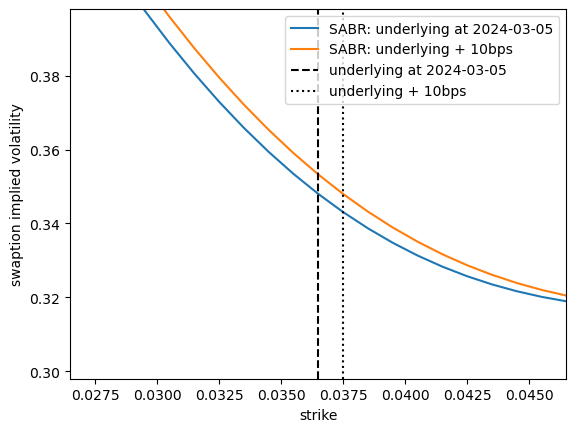

In [29]:
freqcurve = 4
SHIFT = 10/100/100

strikegrid = np.arange(.0025,.09,.001)
if doSLIM:
    ivolgrid = sabr_slim(BETA,nustar,rhostar,F,strikegrid,Topt,volATM)
else:
    ivolgrid = sabr(BETA,nustar,rhostar,alphastar,F,strikegrid,Topt)
    
sabrcurve = pd.DataFrame(ivolgrid,index=strikegrid,columns=['SABR'])

sabrcurve.rename(columns={'SABR':f'SABR: underlying at {DATE}'},inplace=True)
if doSLIM:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr_slim(BETA,nustar,rhostar,F+SHIFT,strikegrid,Topt,volATM)
else:
    sabrcurve[f'SABR: underlying + {SHIFT*100*100:.0f}bps'] = sabr(BETA,nustar,rhostar,alphastar,F+SHIFT,strikegrid,Topt)

fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)
plt.xlim([F-.01,F+.01])
plt.ylim([volATM-.05,volATM+.05])
plt.axvline(F,color='k',linestyle='--',label=f'underlying at {DATE}')
plt.axvline(F+SHIFT,color='k',linestyle=':',label=f'underlying + {SHIFT*100*100:.0f}bps')
plt.ylabel('swaption implied volatility');
plt.xlabel('strike')
plt.legend()

## 4.5.

Use these new prices to calculate and report the approximate delta, for both a static and dynamic vol.

Specifically, calculate the numerical change in price per change in forward rate when...
* holding vol constant
* modeling vol changing according to SABR

How much does the "augmented" delta differ from the classic delta?

In [30]:
fwdswap=swap_rate
idloc = (sabrcurve.index.to_series()-fwdswap).abs().idxmin()

newvols = sabrcurve.loc[idloc]
strikeATM = strikes[-5]

Frange = [F, F+SHIFT]

period_fwd = 1
period_swap = 3

scale=np.sum(df['discounts'].iloc[4:])/4

t=[]
t.append(100 * Blacks_formula(newvols[0],1,NEWSTRIKE,Frange[0],scale,'Put'))
t.append(100 * Blacks_formula(newvols[0],1,NEWSTRIKE,Frange[1],scale,'Put'))

blackprices = pd.Series(t, index=['no change in rates','shift in rates'], name='no change in vol').to_frame().T
blackprices.loc['dynamic vol','shift in rates'] = 100 * Blacks_formula(newvols[1],1,NEWSTRIKE,Frange[1],scale,'Put')
blackprices.style.format('{:.2f}')


,no change in rates,shift in rates
no change in vol,0.37,0.33
dynamic vol,nan,0.34


In [31]:
dprices = (blackprices[['shift in rates']] - blackprices.loc['no change in vol','no change in rates']).rename(columns={'shift in rates':'price change'})
delta = dprices / SHIFT
delta.style.format('{:.2f}')

,price change
no change in vol,-39.96
dynamic vol,-29.60


In [32]:
delta_relative_change = delta.pct_change().loc['dynamic vol','price change']
display(f'Relative change to delta: {delta_relative_change : .2%}.')

'Relative change to delta: -25.92%.'

## 4.6.

Without doing any new calculation, what do you think the effect of a SABR model would be on delta for a payer-swaption in response to a decrease in interest rates?

* Would the delta be positive or negative?
* Would the "augmented" effects of SABR cause the price to be larger or smaller than what the classic delta would imply? 

The delta of a payer swaption (the sensitivity of its price to a small change in interest rates) in response to a decrease in interest rates would likely be negative, as the value of the option to pay fixed and receive floating becomes less valuable when rates fall. 

The "augmented" effects of the SABR model, which accounts for stochastic volatility and the skewness in the distribution of rates, could cause the price change implied by the delta to be larger than what classic Black-Scholes delta might suggest. The SABR model captures more complex dynamics of the market (changing volatility) and its correlation with interest rate movements, potentially amplifying the sensitivity of the swaption's price to changes in rates.

## 4.7.

Consider again the given forward swap rate provided in `4.2` (without the shift considered in part `4.4`.)

Use the SABR vol skew to price the swaption (same expiry and tenor) struck `-300bps` OTM. 

* Report this model price and compare it to the market quote at -300bps.

* Why might we trust the model price more than the provided market quote here?

## 4.8.

What advantage does SABR have over local vol models? 

Be specific.

The SABR model offers the advantage of capturing the volatility smile, a feature often observed in the market where implied volatility varies with strike price and maturity, which local volatility models may struggle to replicate accurately without recalibration for different strikes and maturities. It also incorporates stochastic volatility, allowing for a more robust modeling of volatility dynamics and its correlation with the underlying price, reflecting observed market behaviors that local vol models may oversimplify by assuming constant volatility. Additionally, the SABR model's flexibility and fewer parameters give it statistical power, and make it more adaptable and easier to calibrate to market data, providing more accurate and consistent pricing across a wide range of instruments compared to local volatility models, which may require complex adjustments to fit market conditions.

## 4.9.

For the estimated SABR model in the picture, is ATM implied volatility higher or lower as the interest rate goes higher?

In a sentence, describe specifically what vol path indicates to us about this option market.

(If the figure is not rendering in this cell, find it in `../data/volpath_example.png`.

![title](../data/volpath_example.png)

We can see the vol path decreasing! The vol path shows ATM implied volatilities, so we can literally see it getting lower as the interest rate increases. 

## 4.10.

How do we quantify the **vol path** in SABR? Is it estimated or assumed? Be specific.

The volatility path is quantified through the stochastic process(es), specifically modeled by the volatility equations, which describes how volatility evolves over time. This path is not directly estimated from historical data but is assumed based on the model's parameters: alpha, beta, rho, and nu. These parameters are typically calibrated to market data to reflect the observed market behavior and implied volatility surface, making the volatility path a model assumption that is adjusted to fit market conditions.

***